In [10]:
__author__      = "Alexandre Renaux"
__copyright__   = "Copyright (c) 2023 Alexandre Renaux - Universite Libre de Bruxelles - Vrije Universiteit Brussel"
__license__     = "MIT"
__version__     = "1.0.1"

In [11]:
# Common libraries imports
import os, sys
from collections import defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import matplotlib.ticker as tkr
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import re
import json
import itertools
import datetime
import logging
import warnings
from tqdm import tqdm
from pathlib import Path
from IPython.display import display

# Widespread local imports
from arbock.config.paths import default_paths
from arbock.config.params import default_params
from arbock.utils.cache_utils import Cache
from arbock.utils.parallelizer import MultiprocessingParallelizer
from arbock.utils.dict_utils import max_scaling_dict_vals
from arbock.utils.csv_utils import CSVFileReader, CSVFileWriter
from arbock.data_selection.sample_parser import format_gene_pair
from arbock.data_selection.olida_combination_filters import OLIDAEvidenceFilter
from arbock.data_selection.data_retriever import get_positive_pairs_from_kg, get_trainset_and_holdout

# Logging
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")
logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)
logging.getLogger('seaborn').setLevel(level=logging.CRITICAL)

In [12]:
from arbock.kg.bock import BOCK
kg = BOCK()

INFO:arbock.utils.cache_utils:Getting data from cache at: /Users/alrenaux/Data/bock_rule_mining_caches/bock_graph
INFO:arbock.utils.cache_utils:Getting data from cache at: /Users/alrenaux/Data/bock_rule_mining_caches/bock_index
INFO:arbock.utils.cache_utils:Getting data from cache at: /Users/alrenaux/Data/bock_rule_mining_caches/bock_nomenclature


BOCK Knowledge Graph Statistics
===============================

Node Statistics
---------------

Node count = 158964


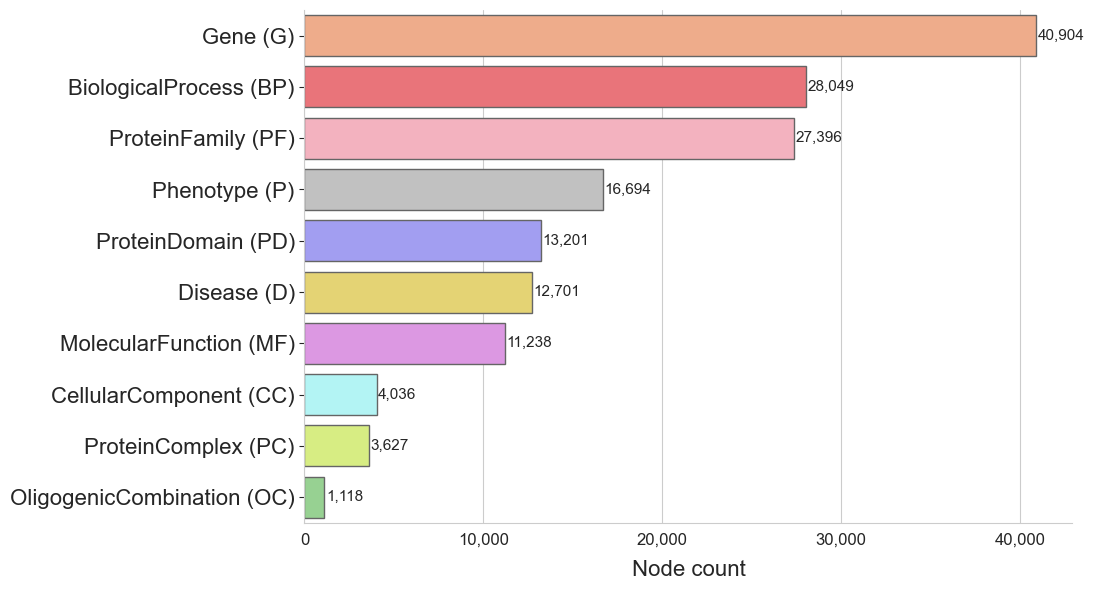

In [6]:
palette = {
        "Gene": "#fea77a",
        "Disease": "#f7e061",
        "BiologicalProcess": "#fc6168",
        "ProteinFamily": "#fea7b9",
        "Phenotype": "#c1c1c1",
        "ProteinDomain": "#9590ff",
        "MolecularFunction": "#e68cee",
        "ProteinComplex": "#e1ff71",
        "OligogenicCombination": "#8edb88",
        "CellularComponent": "#a8ffff",
    }

node_type_counter = defaultdict(int)

node_count = 0
for v in kg.g.vertices():
    node_type = kg.get_node_label(v)
    node_type_counter[node_type] += 1
    node_count += 1

print(f"Node count = {node_count}")

df = pd.DataFrame(node_type_counter.items(), columns=['node_type', 'count'])
df = df.sort_values("count", ascending=False)

node_type_format_dict = {node_type: f"{node_type} ({node_type_abbrev})" for node_type, node_type_abbrev in kg.nomenclature.node_type_to_abbrev.items()}

df["Node type"] = df["node_type"].map(node_type_format_dict)

palette = {node_type_format_dict[k]: v for k,v in palette.items()}

#plt.figure(figsize=(6, 9)) # for publi
plt.figure(figsize=(11, 6))

sns.set_style("whitegrid", rc={'ytick.left': True})

ax = sns.barplot(x="count", y="Node type", data=df, orient="h", palette=palette, linewidth=1, edgecolor="#656565")

ax.tick_params(labelsize=16)

ax.set_xticks([0,10000,20000,30000,40000])
#xlabels = [f'{x/1000:,.0f}k' if x!=0 else '0' for x in ax.get_xticks()] # for publi
xlabels = [f'{x:,.0f}' if x != 0 else '0' for x in ax.get_xticks()]
ax.set_xticklabels(xlabels, fontsize=12)

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
ax.set_xlabel("Node count",fontsize=16, labelpad=9)
ax.set(ylabel=None)
container = ax.containers[0]
ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues], padding=1, fontsize=11)

plt.legend([],[], frameon=False)

plt.tight_layout()

sns.despine(trim=False)

plt.show()

Edge statistics
---------------

In [34]:
edge_type_collect = defaultdict(lambda: defaultdict(set))

edge_count = 0
for e in kg.g.edges():
    target_id = kg.get_edge_property(e, "target")
    source, target = e.source(), e.target()
    if target_id: # Having a property "target" for an edge indicates the directionality of that edge.
        target = e.target() if kg.get_node_property(e.target(), "id") == target_id else e.source()
        source = e.source() if e.source() != target else e.target()

    source_node_type = kg.get_node_label(source)
    target_node_type = kg.get_node_label(target)
    edge_type = kg.get_edge_label(e)
    
    if target_id: # Case where there is a directionality in the edge
        edge_type_collect[(source_node_type, edge_type, target_node_type, 1)]['edges'].add(str(e))
        edge_type_collect[(source_node_type, edge_type, target_node_type, 1)]["sources"].add(int(source))
        edge_type_collect[(source_node_type, edge_type, target_node_type, 1)]["targets"].add(int(target))
    else:
        edge_type_collect[(source_node_type, edge_type, target_node_type, 0)]['edges'].add(str(e))
        edge_type_collect[(source_node_type, edge_type, target_node_type, 0)]["sources"].add(int(source))
        edge_type_collect[(source_node_type, edge_type, target_node_type, 0)]["sources"].add(int(target))
        edge_type_collect[(source_node_type, edge_type, target_node_type, 0)]["targets"].add(int(source))
        edge_type_collect[(source_node_type, edge_type, target_node_type, 0)]["targets"].add(int(target))

    edge_count += 1

df_list = []
for long_edge_type, vals in edge_type_collect.items():
    metaedge = long_edge_type[:3]
    direction = long_edge_type[3]
    pretty_metaedge = kg.nomenclature.prettify_metaedge(metaedge, direction)
    abbrev = kg.nomenclature.abbreviate_metaedge(metaedge, direction)
    n_edges = len(vals["edges"])
    n_sources = len(vals["sources"])
    n_targets = len(vals["targets"])
    df_list.append([pretty_metaedge, abbrev, n_edges, n_sources, n_targets])

pd.options.display.float_format = '{:,}'.format
df_edge_types = pd.DataFrame(df_list, columns=['Metaedge', 'Abbreviation', '# Edges', '# Sources', '# Targets'])
df_edge_types = df_edge_types.sort_values("# Edges", ascending=False)

df_edge_types['# Edges'] = df_edge_types.apply(lambda x: "{:,}".format(x['# Edges']), axis=1)
df_edge_types['# Sources'] = df_edge_types.apply(lambda x: "{:,}".format(x['# Sources']), axis=1)
df_edge_types['# Targets'] = df_edge_types.apply(lambda x: "{:,}".format(x['# Targets']), axis=1)

print(f"Total edge count = {edge_count}")
display(df_edge_types)

Total edge count = 2659082


,Metaedge,Abbreviation,# Edges,# Sources,# Targets
4,Gene--coexpresses--Gene,GeG,"1,338,764","14,940","14,940"
5,Gene--physInteracts--Gene,GpG,"329,801","17,062","17,062"
14,Disease--described--Phenotype,DdP,"232,881","12,629","10,423"
9,Gene--associated--Phenotype,GaP,"209,416","4,870","9,151"
8,Gene--seqSimilar--Gene,GsG,"186,445","12,226","12,226"
3,Gene--associated--BiologicalProcess,GaBP,"93,676","16,323","10,570"
1,Gene--associated--CellularComponent,GaCC,"58,432","16,978",691
2,Gene--belongs--ProteinFamily,GbPF,"45,468","19,658","11,187"
0,Gene--associated--MolecularFunction,GaMF,"43,331","14,540","4,042"
6,Gene--hasUnit--ProteinDomain,GuPD,"41,330","15,830","6,636"


None


Pathogenic gene pairs statistics
================================

Statistics per evidence levels
------------------------------

In [32]:
gene_pair_to_confidence_level = {}
confidence_level_to_infos = defaultdict(lambda: defaultdict(set))
for olida_id, olida_info in kg.index["olida"].items():
    evidences = olida_info["evidences"]
    disease_nodes = olida_info["disease_nodes"]
    confidence_level = OLIDAEvidenceFilter.get_confidence_level(evidences)
    confidence_level_to_infos[confidence_level]["olida_comb"].add(olida_id)
    confidence_level_to_infos[confidence_level]["diseases"].update(disease_nodes)

    if "gene_pair" in olida_info:
        gene_pair = olida_info["gene_pair"]
        gene_pair_to_confidence_level[gene_pair] = max(confidence_level, gene_pair_to_confidence_level.get(gene_pair, 0))

for gene_pair, conf in gene_pair_to_confidence_level.items():
    confidence_level_to_infos[conf]["gene_comb"].add(gene_pair)

levels = {0: "Discarded", 1: "Weak", 2: "Moderate", 3: "Strong"}

confidence_level_to_count = {}
for confidence_level, infos in confidence_level_to_infos.items():
    confidence_level_to_count[levels[confidence_level]] = {
        "# variant combinations": len(infos["olida_comb"]),
        "# gene combinations": len(infos["gene_comb"]),
        "# diseases": len(infos["diseases"])
    }
confidence_level_to_count["Selected"] = {
    "# variant combinations": len(set(itertools.chain.from_iterable([confidence_level_to_infos[i]["olida_comb"] for i in levels if i != 0]))),
    "# gene combinations": len(set(itertools.chain.from_iterable([confidence_level_to_infos[i]["gene_comb"] for i in levels if i != 0]))),
    "# diseases": len(set(itertools.chain.from_iterable([confidence_level_to_infos[i]["diseases"] for i in levels if i != 0]))),
}

df = pd.DataFrame.from_dict(confidence_level_to_count, orient="index")
df = df.loc[list(levels.values()) + ["Selected"]]

display(df)

,# variant combinations,# gene combinations,# diseases
Discarded,324,130,71
Weak,577,280,108
Moderate,131,101,71
Strong,86,60,30
Selected,794,441,153


Independant heldout pathogenic gene pairs
-----------------------------------------

In [60]:
# Function called in the arbock.py code to retrieve the positive training and testing data:

min_confidence_level = 1 # Minimum criteria (=Weak) for selecting all positives
holdout_positive_size = 15 # Number of heldout independant pathogenic gene pairs
holdout_min_confidence_level = 2 # Minimum criteria (=Moderate) for selecting heldout pathogenic gene pairs
training_pos_w, holdout_pos_w, gene_pairs_to_disease_ids = get_positive_pairs_from_kg(kg, min_confidence_level, holdout_positive_size, holdout_min_confidence_level)

# Some indexing to collect extra properties from the KG to show on the table (timestamps & PMIDs)
gene_pairs_to_timestamps = defaultdict(list)
gene_pairs_to_pmids = defaultdict(set)
for olida_id, properties in kg.index["olida"].items():
    if "gene_pair" in properties:
        node_pair = properties["gene_pair"]
        ensg_pair = tuple([kg.get_node_property(n, "id") for n in node_pair])
        timestamp = properties["timestamp"]
        gene_pairs_to_timestamps[ensg_pair].append(timestamp)
        gene_pairs_to_pmids[ensg_pair].update(properties.get("PMIDs", []))
filtered_gene_pair_to_timestamp = {}
for gene_pair, timestamps in gene_pairs_to_timestamps.items():
    min_timestamp = min(timestamps)
    filtered_gene_pair_to_timestamp[gene_pair] = min_timestamp

# Displaying the information about the selected independant gene pairs
levels = {0: "Discarded", 1: "Weak", 2: "Moderate", 3: "Strong"}
df_list = []
for holdout_gene_pair, w in holdout_pos_w.items():
    disease_ids = gene_pairs_to_disease_ids[holdout_gene_pair]
    level = levels[w * 3]
    gene_pair_names = "-".join([kg.get_node_property(kg.index['id'][ensg_id], 'name') for ensg_id in holdout_gene_pair])
    disease_name = "-".join([kg.get_node_property(kg.index['id'][disease_id], 'name') for disease_id in disease_ids])
    timestamp = filtered_gene_pair_to_timestamp[holdout_gene_pair]
    formatted_date = datetime.datetime.fromtimestamp(timestamp).strftime('%d/%m/%Y')
    pmid = ";".join(gene_pairs_to_pmids[holdout_gene_pair])
    df_list.append([gene_pair_names, level, disease_name, pmid, formatted_date, timestamp])

df = pd.DataFrame(df_list, columns=["Gene pair", "Evidence level", "Disease", "PMID", "Publication Date", "Timestamp"])
df = df.sort_values(by="Timestamp", ascending=False)
display(df)

,Gene pair,Evidence level,Disease,PMID,Publication Date,Timestamp
5,MYH7-ANKRD1,Moderate,Left ventricular noncompaction,34752814,06/11/2021,1636212961
8,LAMA3-LAMB3,Moderate,Severe generalized junctional epidermolysis bu...,34837689,01/10/2021,1633039200
10,TSHR-SLC26A4,Moderate,Congenital hypothyroidism,34374102,10/08/2021,1628569759
11,JAG1-DUOXA1,Moderate,Congenital hypothyroidism,34374102,10/08/2021,1628569759
12,CDCA8-DUOX2,Moderate,Congenital hypothyroidism,34374102,10/08/2021,1628569759
13,HOXB3-TG,Moderate,Congenital hypothyroidism,34374102,10/08/2021,1628569759
9,MYO7A-SHROOM2,Strong,Atypical hemolytic uremic syndrome,34391192,02/08/2021,1627917936
4,PKHD1-PKD1,Moderate,Autosomal recessive polycystic kidney disease,34032358,25/05/2021,1621938525
7,POLG-PPFIA4,Moderate,Isolated focal cortical dysplasia,34095804,07/05/2021,1620407049
6,SLC20A2-PDGFRB,Moderate,Bilateral striopallidodentate calcinosis,33793087,01/04/2021,1617282236


Pathogenic gene pair path reachability
======================================

(Warning: this one takes a while to be computed, but then it is cached!)

INFO:arbock.utils.cache_utils:Getting data from cache at: /Users/alrenaux/Data/bock_rule_mining_caches/network_type_to_gene_pair_to_min_path


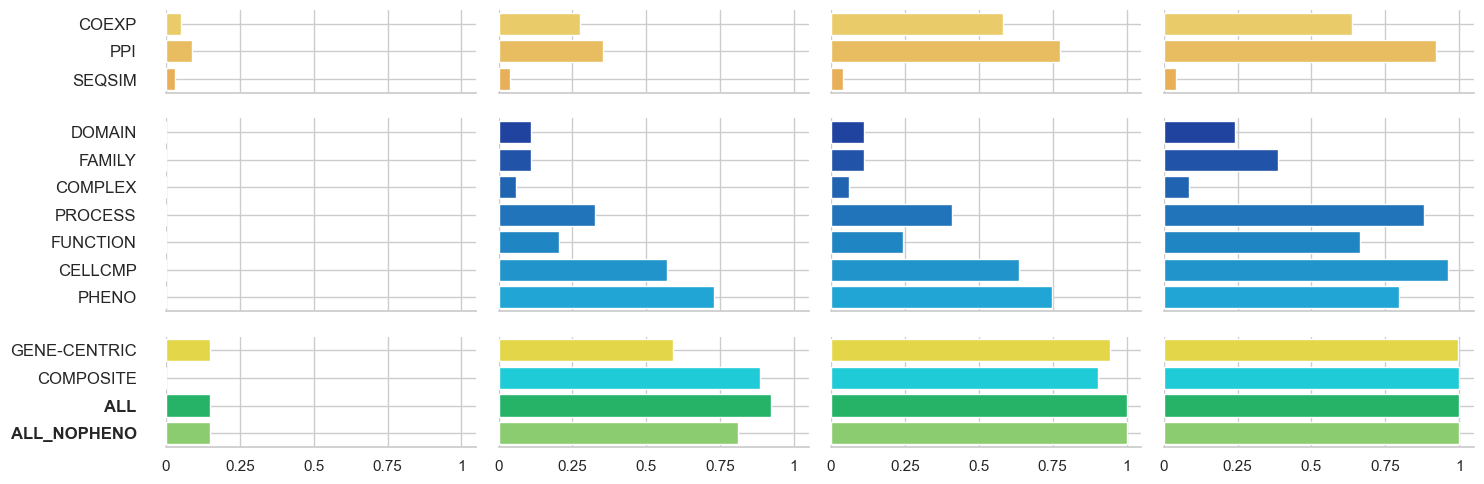

In [63]:
MAX_PATH_LENGTH = 4
_DEFAULT_EXCLUDED_NODE_TYPES = {"OligogenicCombination", "Disease"}

# Key = Network type name
# Value = valid_edge_types, valid_node_types, filter_means_retain
network_types = {
    "SEQSIM": (["seqSimilar"], ["Gene"], True),
    "COEXP": (["coexpresses"], ["Gene"], True),
    "PPI": (["physInteracts"], ["Gene"], True),
    "GENE-CENTRIC": (["coexpresses", "seqSimilar", "physInteracts"], ["Gene"], True),
    "DOMAIN": (["hasUnit"], ["Gene", "ProteinDomain"], True),
    "FAMILY": (["belongs"], ["Gene", "ProteinFamily"], True),
    "COMPLEX": (["forms"], ["Gene", "ProteinComplex"], True),
    "PROCESS": (["associated", "resembles"], ["Gene", "BiologicalProcess"], True),
    "FUNCTION": (["associated", "resembles"], ["Gene", "MolecularFunction"], True),
    "CELLCMP": (["associated", "resembles"], ["Gene", "CellularComponent"], True),
    "PHENO": (["associated", "resembles"], ["Gene", "Phenotype"], True),
    "COMPOSITE": (["hasUnit", "belongs", "forms", "associated", "resembles"], ["Gene", "ProteinDomain", "ProteinFamily", "ProteinComplex", "BiologicalProcess", "MolecularFunction", "CellularComponent", "Phenotype"], True),
    "ALL": (["causes", "involves", "described"], ["OligogenicCombination", "Disease"], False),
    "ALL_NOPHENO": (["causes", "involves", "described"], ["OligogenicCombination", "Disease", "Phenotype"], False)
}

def get_network_types(edge_types, node_types):
    node_types = set(node_types)
    edge_types = set(edge_types)
    matches = set()
    for network_type, (valid_edge_types, valid_node_types, filter_means_retain) in network_types.items():
        edge_match = edge_types.intersection(valid_edge_types)
        node_match = node_types.intersection(valid_node_types)
        if (filter_means_retain and len(edge_match) == len(edge_types) and len(node_match) == len(node_types)) or (not filter_means_retain and len(edge_match) == 0 and len(node_match) == 0):
            matches.add(network_type)
    return matches

def _get_filtered_network(filters):
    oligoKG = BOCK(default_paths.kg_graphml, update_cache=False)
    edge_filter, node_filter, filter_means_keep = filters
    filter_flags = oligoKG.get_filter_flags(edge_filter, node_filter, filter_means_keep=filter_means_keep)
    oligoKG.filter_node_and_edges(filter_flags)
    return oligoKG

def get_filtered_network(network_type, filters, update_cache=False):
    storage = Cache(f"oligoKG_subnetwork_{network_type}", update_cache, single_file=True)
    return storage.get_or_store("", lambda x: _get_filtered_network(filters))

def sanitycheck_network_types(oligoKG, network_types):
    edge_types = oligoKG.get_all_edge_types()
    node_types = oligoKG.get_all_node_types()
    for network_type, filters in network_types.items():
        edge_filter, node_filter, filter_means_keep = filters
        if isinstance(edge_filter, list):
            for edge_type in edge_filter:
                assert edge_type in edge_types, f"{edge_type} not in edge_types"
        for node_type in node_filter:
            assert node_type in node_types, f"{node_type} not in node_types"

def valid_path(p, kg, forbidden_node_types):
    for edge in p:
        target_node_type = kg.get_node_label(edge.target())
        if target_node_type in forbidden_node_types:
            return False
    return True

def _get_data(mpp, update_subnet_cache=False):

    oligoKG = BOCK(default_paths.kg_graphml, update_cache=False)

    training_pos_w, holdout_pos_w, gene_pairs_to_disease_ids = get_positive_pairs_from_kg(oligoKG, min_confidence_level=1, holdout_positive_size=0)
    positive_gene_pairs = set(training_pos_w.keys())
    
    sanitycheck_network_types(oligoKG, network_types)

    max_cutoff = MAX_PATH_LENGTH

    network_type_to_gene_pair_to_min_pathl = defaultdict(lambda: defaultdict(set))

    for network_type, filters in network_types.items():
        print(f"computing {network_type}")

        oligoKG = get_filtered_network(network_type, filters, update_cache=update_subnet_cache)

        if mpp:
            results = mpp.map_collect(process_paths, positive_gene_pairs, None, {"oligoKG": oligoKG})
        else:
            results = [process_paths(gene_pair, oligoKG) for gene_pair in tqdm(positive_gene_pairs)]

        for result in results:
            min_path_length, source_id, target_id = result
            if min_path_length != float("inf"):
                for incl_path_length in range(min_path_length, max_cutoff+1):
                    network_type_to_gene_pair_to_min_pathl[incl_path_length][network_type].add((source_id, target_id))

    return dict(network_type_to_gene_pair_to_min_pathl), len(positive_gene_pairs)

def get_data(mpp, update_path_cache=False, update_subnet_cache=False):
    storage = Cache(f"network_type_to_gene_pair_to_min_path", update_path_cache, single_file=True)
    return storage.get_or_store("", lambda x: _get_data(mpp, update_subnet_cache))

def process_paths(ensg_pair, oligoKG):
    gene_node_pair = oligoKG.orient_pair([oligoKG.index["id"][ensg] for ensg in ensg_pair])
    source, target = gene_node_pair
    source_id = gene_node_pair[0]
    target_id = gene_node_pair[1]
    min_path_length = shortest_distance(oligoKG.g, source, target)
    return min_path_length, source_id, target_id

def plot_data(network_type_to_gene_pair_to_min_pathl, total_gp_count, max_path_length=3):

    sub_ys = {"Gene-centric networks": ["COEXP", "PPI", "SEQSIM"],
              "Composite networks" : ["DOMAIN", "FAMILY", "COMPLEX", "PROCESS", "FUNCTION", "CELLCMP", "PHENO"],
              "Integrated" : ["GENE-CENTRIC", "COMPOSITE", "ALL", "ALL_NOPHENO"]}

    sns.set_theme(style="whitegrid")
    base_palette = {
        "Gene-centric networks": ["#ffd655", "#ffc54a", "#ffb43f"],
        "Composite networks": ['#0b3ab4','#0a4fbf','#0863c9','#0777d3','#058bde','#049fe8','#02b3f2'],
        "Integrated": ['#fced30', '#00e6f4', "#0fca67", "#84dc5f"]
    }

    palettes = []
    for sub_y_name, sub_y_nets in sub_ys.items():
        palettes.append(sns.palettes._ColorPalette(base_palette[sub_y_name]))

    f, axs = plt.subplots(3, max_path_length,
                          figsize=(15,5), sharex="all", sharey="row",
                          gridspec_kw={'height_ratios': [3, 7, 4]})

    sub_y_n = 0
    for sub_y_name, sub_y_nets in sub_ys.items():
        plot_n = 0
        for path_length, network_type_to_gene_pairs in sorted(network_type_to_gene_pair_to_min_pathl.items(), key=lambda x: x[0]):
            sns.set_palette(palettes[sub_y_n])
            network_type_to_size = {n:len(gene_pairs) for n,gene_pairs in network_type_to_gene_pairs.items()}

            sub_network_type_to_size = {}
            for sub_y_net in sub_y_nets:
                sub_network_type_to_size[sub_y_net] = network_type_to_size.get(sub_y_net, 0)

            df = pd.DataFrame.from_dict(sub_network_type_to_size, orient="index", columns=["Linked OLIDA gene pair"])
            df["Network type"] = df.index
            df["Linked OLIDA gene pair ratio"] = df["Linked OLIDA gene pair"] / total_gp_count
            #df = df.sort_values(by="Linked OLIDA gene pair ratio")

            if len(df):
                ax = sns.barplot(x="Linked OLIDA gene pair ratio", y="Network type", data=df, ax=axs[sub_y_n, plot_n])
                ax.set(xlabel=None)
                ax.set(ylabel=None)
                xticks = [0, 0.25, 0.50, 0.75, 1]
                xtickLabels = map(str, xticks)
                ax.set_xticks(xticks)
                ax.set_xticklabels(xtickLabels)
                ax.yaxis.grid(True) # Hide the horizontal gridlines
                ax.xaxis.grid(True) # Show the vertical gridlines
                ax.tick_params(axis='y', labelsize=12, pad=15)

                sns.despine(left=True, bottom=False)
            plot_n += 1
        sub_y_n += 1

    for i in range(0,3):
        ax = axs[i, 0]
        ax.tick_params(axis='y', labelsize=12, pad=15)
    axs[2, 0].get_yticklabels()[2].set_weight('bold')
    axs[2, 0].get_yticklabels()[3].set_weight('bold')

    f.tight_layout()
    f.subplots_adjust(hspace=0.2)
    plt.show()

mpp = MultiprocessingParallelizer()
data, total_gp_count = get_data(mpp, update_path_cache=False, update_subnet_cache=False)
plot_data(data, total_gp_count, max_path_length=MAX_PATH_LENGTH)

# Plot columns represents path_cutoff <= 1 ; 2 ; 3; 4.

Annotation coverage bias in pathogenic gene pairs
=================================================

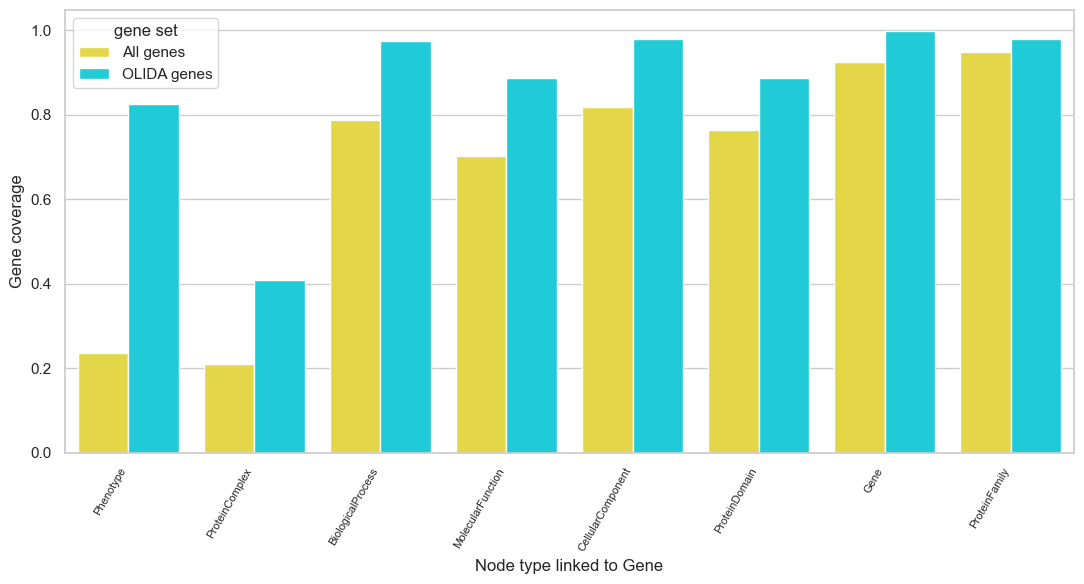

In [78]:
forbidden_node_labels = ["OligogenicCombination"]

label_to_count_all = defaultdict(int)
label_to_count_olida = defaultdict(int)

olida_genes = set()
for combination, properties in kg.index["olida"].items():
    if "gene_pair" in properties:
        evidence_level = OLIDAEvidenceFilter.get_confidence_level(properties["evidences"])
        if evidence_level >= 1:
            gene_pair = properties["gene_pair"]
            olida_genes.update(gene_pair)
            labels = set()

all_valid_genes = set()
for node in kg.g.vertices():
    if kg.get_node_label(node) == "Gene":
        unique_labels = set()
        connected = False
        for neigh in kg.g.get_all_neighbors(node):
            neigh_label = kg.get_node_label(neigh)
            unique_labels.add(neigh_label)
            connected = True
        if connected: # Discard orphan genes
            all_valid_genes.add(node)
        for label in unique_labels:
            if label not in forbidden_node_labels:
                labels.add(label)
                if connected:
                    label_to_count_all[label] += 1
                if node in olida_genes:
                    label_to_count_olida[label] += 1

df_dict = {"All genes": max_scaling_dict_vals(label_to_count_all, len(all_valid_genes)), "OLIDA genes": max_scaling_dict_vals(label_to_count_olida, len(olida_genes))}

label_to_diff = {label: df_dict["OLIDA genes"][label] - df_dict["All genes"][label] for label in labels}
sorted_labels = [x[0] for x in sorted(label_to_diff.items(), key=lambda x: x[1], reverse=True)]

df = pd.DataFrame.from_dict(df_dict, orient="index")
df = df[sorted_labels]
df["gene set"] = df.index

df_melted = pd.melt(df, id_vars=("gene set"), var_name="Node type linked to Gene", value_name="Gene coverage")

fig = plt.figure(figsize=(11,6))

g = sns.barplot(x='Node type linked to Gene', y='Gene coverage', hue='gene set', data=df_melted)

g.set_xticklabels(g.get_xticklabels(),
                          rotation=60,
                          horizontalalignment='right',
                            fontsize=8)

plt.tight_layout()
plt.show()

Decision models performance evaluation
======================================

Cross-validation ROC / PR curves
--------------------------------

Best threshold: 0.929 (TPRs 0.814 ; FPRs 0.065, BA 0.875)
Mean ROC avg AUC = 0.903  ; std. 0.03)
Best threshold: 0.788 (TPRs 0.747 ; FPRs 0.233, BA 0.757)
Mean ROC avg AUC = 0.810  ; std. 0.03)
Mean PR (avg AUC = 0.548 ; std 0.07)
Mean PR (avg AUC = 0.200 ; std 0.07)


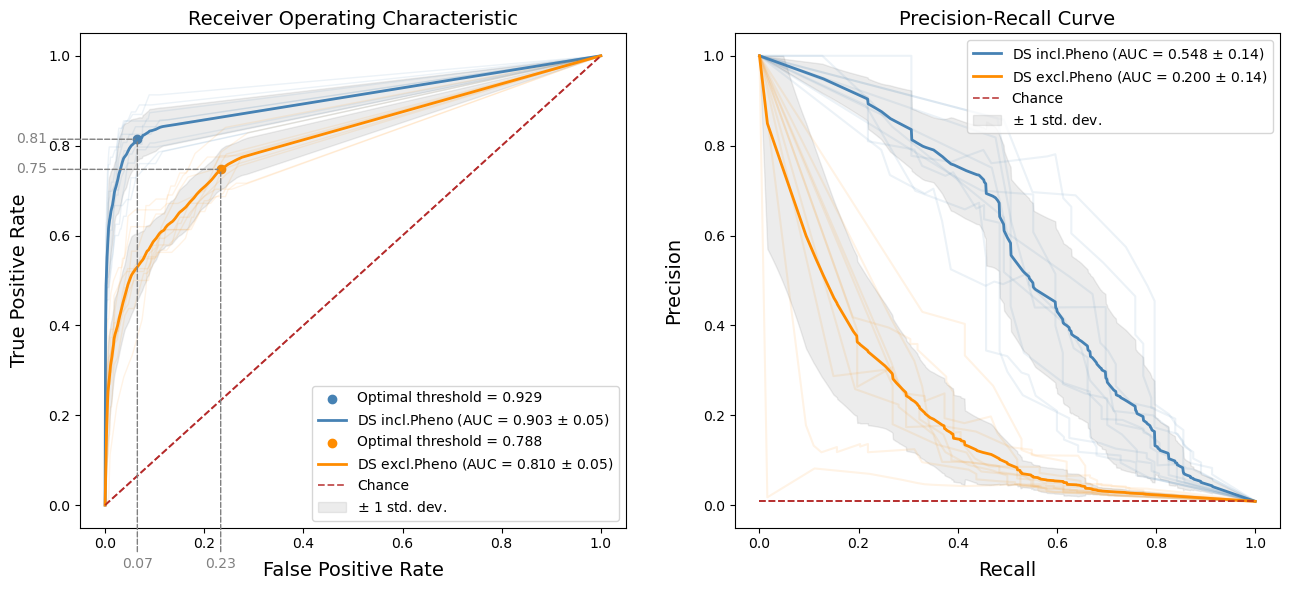

In [83]:
from arbock.model.performance_evaluation import xval_roc_curve, xval_pr_curve

def get_xval_prediction_data(pred_csv):
    df = pd.read_csv(pred_csv, sep="\t")
    folds_y_true = []
    folds_y_scores = []
    folds_weights = []

    for index, values in df.iterrows():
        predictions = json.loads(values["predictions"])
        y = json.loads(values["y"])
        weights = json.loads(values["sample_weights"])

        folds_y_true.append(np.array(y))
        folds_y_scores.append(np.array(predictions))
        folds_weights.append(weights)

    return folds_y_true, folds_y_scores, folds_weights

folds_y_true_pheno, folds_y_scores_pheno, folds_weights_pheno = get_xval_prediction_data("models/article_predictions/ds_with_pheno_xval_predictions.tsv")
folds_y_true_no_pheno, folds_y_scores_no_pheno, folds_weights_no_pheno = get_xval_prediction_data("models/article_predictions/ds_no_pheno_xval_predictions.tsv")

fig, ax = plt.subplots(1, 2, figsize=(13, 6))

xval_roc_curve("DS incl.Pheno", folds_y_true_pheno, folds_y_scores_pheno, folds_weights_pheno, ax=ax[0],
                    plot_color='steelblue', display_extra_legends=False)
xval_roc_curve("DS excl.Pheno", folds_y_true_no_pheno, folds_y_scores_no_pheno, folds_weights_no_pheno, ax=ax[0],
                    plot_color='darkorange')

xval_pr_curve("DS incl.Pheno", folds_y_true_pheno, folds_y_scores_pheno, folds_weights_pheno, ax=ax[1],
                   plot_color='steelblue', display_extra_legends=False)
xval_pr_curve("DS excl.Pheno", folds_y_true_no_pheno, folds_y_scores_no_pheno, folds_weights_no_pheno, ax=ax[1],
                   plot_color='darkorange')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.show()

Independant heldout test set
----------------------------

In [39]:
# Imports and functions

from arbock.model.decision_set_classifier import DecisionSetClassifier
from arbock.path_traversal.metapath_extracter import MetapathExtracter

def read_digepred_results(input_path, kg):
    ensg_pair_to_proba = {}
    with CSVFileReader(input_path, has_header=True, delimiter="\t") as f:
        for row in f:
            gene_pair = eval(row[""])
            proba = float(row["unaffected-no-gene-overlap"])
            ensg_pair = format_gene_pair(gene_pair[0], gene_pair[1], kg, input_gene_format="HGNC")
            ensg_pair_to_proba[ensg_pair] = proba
    return ensg_pair_to_proba

def bock_predict_on_gene_pairs(model_path, gene_pairs, kg, algo_params, update_mp_cache=False):
    model_name = os.path.basename(Path(model_path).with_suffix(""))
    decision_set_classifier = DecisionSetClassifier.instanciate(model_path)
    metapath_dict = MetapathExtracter(algo_params).run(gene_pairs, kg, f"eval_indeps_{model_name}", update_cache=update_mp_cache)
    ordered_samples, predict_probas, explanations = decision_set_classifier.predict_and_explain(gene_pairs, metapath_dict)
    gp_to_proba_expl = {}
    for sample, proba, explanation in zip(ordered_samples, predict_probas, explanations):
        gp_to_proba_expl[sample] = (proba[1], explanation)
    return gp_to_proba_expl

def get_pheno_kg_information(gp, kg):
    geneA, geneB = gp
    node_A = kg.index["id"][geneA]
    phenos_linked_A = set()
    for e in kg.g.vertex(node_A).all_edges():
        target = e.target()
        if kg.get_node_label(target) == "Phenotype":
            phenos_linked_A.add(kg.get_node_property(target, "id"))
    node_B = kg.index["id"][geneB]
    phenos_linked_B = set()
    for e in kg.g.vertex(node_B).all_edges():
        target = e.target()
        if kg.get_node_label(target) == "Phenotype":
            phenos_linked_B.add(kg.get_node_property(target, "id"))

    common_phenos = phenos_linked_A.intersection(phenos_linked_B)
    union_phenos = phenos_linked_A.union(phenos_linked_B)
    pheno_sim = len(common_phenos) / len(union_phenos) if len(union_phenos) != 0 else 0
    return len(phenos_linked_A), len(phenos_linked_B), pheno_sim

def prepare_dataframe(gp_to_digepred_pred, gp_to_bock_pheno_pred, gp_to_bock_nopheno_pred, kg):
    df_dict = defaultdict(dict)
    for gp, digepred_proba in gp_to_digepred_pred.items():
        df_dict[gp]["digepred_proba"] = digepred_proba
    for gp, bock_nopheno_res in gp_to_bock_nopheno_pred.items():
        bock_nopheno_proba, bock_nopheno_expl = bock_nopheno_res
        df_dict[gp]["bock_nopheno_proba"] = bock_nopheno_proba
    for gp, bock_pheno_res in gp_to_bock_pheno_pred.items():
        bock_pheno_proba, bock_pheno_expl = bock_pheno_res
        df_dict[gp]["bock_pheno_proba"] = bock_pheno_proba
        if bock_pheno_expl:
            for rule in bock_pheno_expl:
                for metapath in rule.antecedent.metapaths:
                    edge_types, node_types, edge_directions = metapath
                    if "Phenotype" in node_types:
                        df_dict[gp]["match_pheno_rules"] = 1
                        if len(node_types) == 2:
                            df_dict[gp]["match_indirect_pheno_rules"] = 1
                            break
        if "match_pheno_rules" not in df_dict[gp]:
            df_dict[gp]["match_pheno_rules"] = 0
        if "match_indirect_pheno_rules" not in df_dict[gp]:
            df_dict[gp]["match_indirect_pheno_rules"] = 0
    for gp in gp_to_digepred_pred:
        nb_pheno_A, nb_pheno_B, pheno_sim = get_pheno_kg_information(gp, kg)
        df_dict[gp]["min_pheno"] = min(nb_pheno_A, nb_pheno_B)
        df_dict[gp]["nb_pheno_A"] = nb_pheno_A
        df_dict[gp]["nb_pheno_B"] = nb_pheno_B
        df_dict[gp]["pheno_sim"] = pheno_sim
        df_dict[gp]["name"] = "-".join([kg.get_node_property(kg.index["id"][g], "name") for g in gp])

    df = pd.DataFrame.from_dict(df_dict, orient="index")
    return df

# Data preparation
digepred_indep_result_path = "models/article_predictions/digepred_independent_predictions.csv"
model_without_pheno_path = "models/ds_model_no_pheno"
model_pheno_path = "models/ds_model_with_pheno"

DIGEPRED_THRESHOLD = 0.496
BOCK_DS_THRESHOLD = 0.788
BOCK_DS_WITH_PHENO_THRESHOLD = 0.929

min_confidence_level = 1 # Minimum criteria (=Weak) for selecting all positives
holdout_positive_size = 15 # Number of heldout independant pathogenic gene pairs
holdout_min_confidence_level = 2 # Minimum criteria (=Moderate) for selecting heldout pathogenic gene pairs

update_metapath_caches = False

gp_to_digepred_pred = read_digepred_results(digepred_indep_result_path, kg)

training_pos_w, holdout_pos_w, gene_pairs_to_disease_ids = get_positive_pairs_from_kg(kg, min_confidence_level, holdout_positive_size, holdout_min_confidence_level)
algo_params_no_pheno = {"excl_node_types": {"OligogenicCombination", "Disease", "Phenotype"}, "path_cutoff": 3}
gp_to_bock_nopheno_pred = bock_predict_on_gene_pairs(model_without_pheno_path, holdout_pos_w.keys(), kg, algo_params_no_pheno, update_mp_cache=update_metapath_caches)
algo_params_with_pheno = {"excl_node_types": {"OligogenicCombination", "Disease"}, "path_cutoff": 3}
gp_to_bock_pheno_pred = bock_predict_on_gene_pairs(model_pheno_path, holdout_pos_w.keys(), kg, algo_params_with_pheno, update_mp_cache=update_metapath_caches)

indep_preds_df = prepare_dataframe(gp_to_digepred_pred, gp_to_bock_pheno_pred, gp_to_bock_nopheno_pred, kg)

print("Independant gene pair data successfully prepared.")

INFO:arbock.data_selection.olida_combination_filters:Holding out 15 combinations from the positive training set. Temporal filtering starting from publication date: 30/09/2020.
INFO:arbock.path_traversal.metapath_extracter:Running metapath extracter on 15 entity pairs. [path_cutoff=3, excl_node_types={'OligogenicCombination', 'Disease', 'Phenotype'}]
INFO:arbock.utils.cache_utils:Getting data from cache at: /Users/alrenaux/Data/bock_rule_mining_caches/eval_indeps_ds_model_no_pheno_metapath_extracter_path_cutoff_3_excl_node_types_Disease-OligogenicCombination-Phenotype
INFO:arbock.path_traversal.metapath_extracter:Running metapath extracter on 15 entity pairs. [path_cutoff=3, excl_node_types={'OligogenicCombination', 'Disease'}]
INFO:arbock.utils.cache_utils:Getting data from cache at: /Users/alrenaux/Data/bock_rule_mining_caches/eval_indeps_ds_model_with_pheno_metapath_extracter_path_cutoff_3_excl_node_types_Disease-OligogenicCombination


Independant gene pair data successfully prepared.


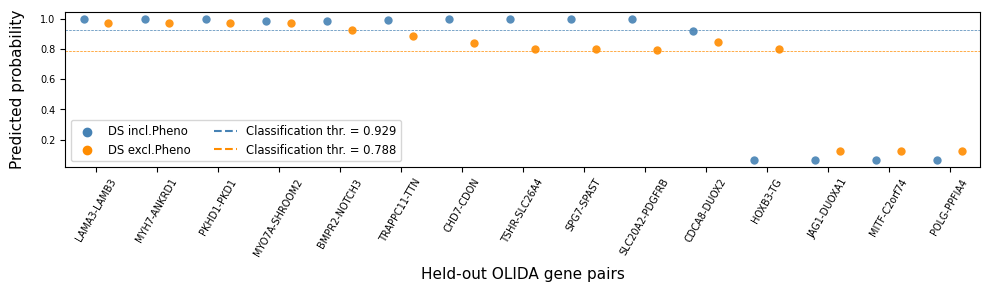

In [36]:
def plot_decision_sets_independant_predictions(df):

    # reshape the dataframe to long format
    long_df = df.melt(id_vars='name',
                      value_vars=[f"bock_pheno_proba", f"bock_nopheno_proba"],
                      var_name='Type',
                      value_name='proba')

    # mapping from variable names to type labels
    type_mapping = {
        "bock_pheno_proba": "DS incl.Pheno",
        "bock_nopheno_proba": "DS excl.Pheno"
    }
    long_df["Type"] = long_df["Type"].map(type_mapping)

    # sort by average probability
    sorted_index = long_df.groupby('name')['proba'].mean().sort_values(ascending=False).index
    long_df = long_df.set_index('name').loc[sorted_index].reset_index()

    plt.figure(figsize=(10, 3))

    thresholds = {"DS incl.Pheno": BOCK_DS_WITH_PHENO_THRESHOLD, "DS excl.Pheno": BOCK_DS_THRESHOLD}
    colors = {"DS incl.Pheno": "steelblue", "DS excl.Pheno": "darkorange"}

    # draw swarmplot
    ax = sns.swarmplot(data=long_df, x="name", y="proba", hue="Type", palette=colors, dodge=True, size=6, edgecolor="black", linewidth=0, alpha=0.9)

    # draw thresholds
    for res_type, color in colors.items():
        ax.axhline(thresholds[res_type], linestyle="dashed", linewidth=0.5, color=color)

    ax.set_ylabel('Predicted probability', size=11, labelpad=11)
    ax.set_xlabel('Held-out OLIDA gene pairs', size=11, labelpad=7)

    for label in ax.get_xticklabels():
        label.set_rotation(60)
    ax.tick_params(labelsize=7)

    # legend settings for the points and the thresholds
    handles, labels = ax.get_legend_handles_labels()
    line1 = Line2D([0], [0], linestyle="dashed", color=colors["DS incl.Pheno"])
    line2 = Line2D([0], [0], linestyle="dashed", color=colors["DS excl.Pheno"])
    handles += [line1, line2]
    labels += [f"Classification thr. = {thresholds['DS incl.Pheno']}", f"Classification thr. = {thresholds['DS excl.Pheno']}"]

    # remove old legend
    ax.get_legend().remove()

    # create new legend
    leg = plt.legend(handles=[handles[i] for i in range(len(handles))],
                     labels=[labels[i] for i in range(len(labels))],
                     loc='lower left', ncol=2, fontsize='small')
    leg.get_title().set_fontsize('small')
    #leg.set_title("Decision Set Models' Predictions")

    plt.tight_layout()

    plt.show()
    plt.clf()
    plt.close()

plot_decision_sets_independant_predictions(indep_preds_df)

Model comparison with regards to Phenotype
------------------------------------------

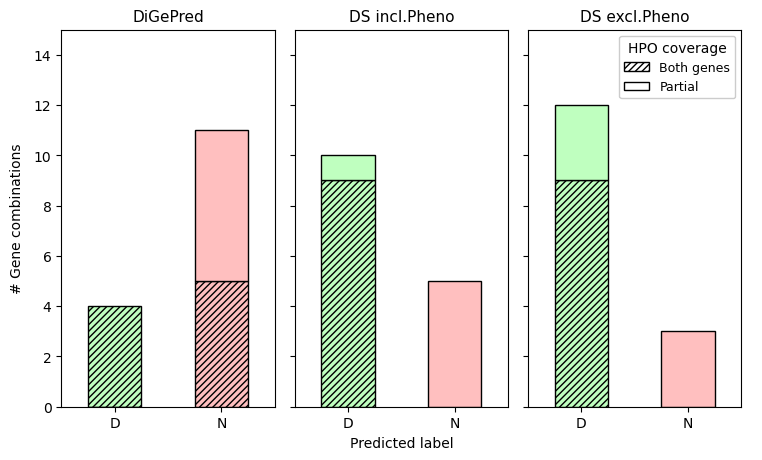

In [37]:
def model_comparison_and_phenotype_annot_barplot(df):

    score_cols_to_method_name_thr = {"digepred_proba": ("DiGePred", DIGEPRED_THRESHOLD),
                                     "bock_pheno_proba": ("DS incl.Pheno", BOCK_DS_WITH_PHENO_THRESHOLD),
                                     "bock_nopheno_proba": ("DS excl.Pheno", BOCK_DS_THRESHOLD)
                          }

    fig, axes = plt.subplots(figsize=(8,5), nrows=1, ncols=3, sharey="all")


    for i, col_to_method_name_thr in enumerate(score_cols_to_method_name_thr.items()):
        col, method_name_thr = col_to_method_name_thr
        method_name, method_thr = method_name_thr

        new_df_list = []
        tot = 0
        for label, comp in {"D": f">= {method_thr}", "N":f"< {method_thr}"}.items():
            pos_with_pheno = len(df.query(f"{col} {comp} and min_pheno > 0"))
            pos_without_pheno = len(df.query(f"{col} {comp} and min_pheno == 0"))
            tot += pos_with_pheno + pos_without_pheno
            new_df_list.append((label, pos_with_pheno, pos_without_pheno))
        new_df = pd.DataFrame(new_df_list, columns=["prediction", "Both genes", "Partial"])
        ax = new_df.set_index("prediction").plot(kind="bar", stacked=True, ax=axes[i], edgecolor = "black")
        bars = [thing
                for thing in ax.containers if isinstance(thing,mpl.container.BarContainer)]
        patterns = itertools.cycle(('/////', '/////', '', ''))
        color_patterns = itertools.cycle(("#BFFFBF", "#FFBFBF", "#BFFFBF", "#FFBFBF"))
        for bar in bars:
            for bar_container in bar:
                pattern = next(patterns)
                color = next(color_patterns)
                bar_container.set_facecolor(color)
                bar_container.set_hatch(pattern)
        ax.set_title(f"{method_name}", fontsize=11, alpha=1.0)
        ax.set_ylim([0, tot])
        ax.set_xticklabels(["D", "N"], rotation=0)
        ax.set_xlabel("")

    axes[0].legend().set_visible(False)
    axes[1].legend().set_visible(False)
    axes[2].legend(title="HPO coverage", loc='upper right', fontsize=9).get_frame().set_alpha(1.0)

    for ax in axes:
        for leghandle in ax.get_legend().legendHandles:
            leghandle.fill = False

    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Predicted label")
    plt.ylabel("# Gene combinations")

    plt.tight_layout()
    plt.show()

model_comparison_and_phenotype_annot_barplot(indep_preds_df)

In [38]:
# Detail table of the comparison above.
pd.options.display.float_format = '{:,.2f}'.format
indep_preds_df = indep_preds_df[["name", "nb_pheno_A", "nb_pheno_B", "pheno_sim", "digepred_proba", "bock_pheno_proba", "bock_nopheno_proba"]]
indep_preds_df.columns = ["Gene pair (A,B)", "# Phenotypes A", "# Phenotypes B", "Phenotype similarity (A,B)", "DiGePred pred.", "BOCK DS incl. Phenotype", "BOCK DS pred."]
indep_preds_df = indep_preds_df.sort_values(by=["Phenotype similarity (A,B)", "# Phenotypes A", "# Phenotypes B"])
display(indep_preds_df)

,,"Gene pair (A,B)",# Phenotypes A,# Phenotypes B,"Phenotype similarity (A,B)",DiGePred pred.,BOCK DS incl. Phenotype,BOCK DS pred.
ENSG00000120093,ENSG00000042832,HOXB3-TG,0,32,0.00,0.00,0.06,0.80
ENSG00000134690,ENSG00000140279,CDCA8-DUOX2,0,38,0.00,0.01,0.92,0.84
ENSG00000137474,ENSG00000146950,MYO7A-SHROOM2,34,0,0.00,0.02,0.98,0.97
ENSG00000187098,ENSG00000237651,MITF-C2orf74,58,0,0.00,0.02,0.06,0.12
ENSG00000101384,ENSG00000140254,JAG1-DUOXA1,96,0,0.00,0.01,0.06,0.12
ENSG00000140521,ENSG00000143847,POLG-PPFIA4,245,0,0.00,0.03,0.06,0.12
ENSG00000204217,ENSG00000074181,BMPR2-NOTCH3,19,133,0.01,0.05,0.98,0.93
ENSG00000092054,ENSG00000148677,MYH7-ANKRD1,171,8,0.05,0.23,1.00,0.97
ENSG00000170927,ENSG00000008710,PKHD1-PKD1,75,27,0.10,0.03,1.00,0.97
ENSG00000171316,ENSG00000064309,CHD7-CDON,217,116,0.10,0.38,1.00,0.84


Random-walk with restart performance
====================================

INFO:arbock.data_selection.olida_combination_filters:Holding out 15 combinations from the positive training set. Temporal filtering starting from publication date: 30/09/2020.
INFO:arbock.data_selection.data_retriever:Training data sizes: 426 positives | 44100 negatives | 15 holdout positives
INFO:arbock.data_selection.olida_combination_filters:Holding out 15 combinations from the positive training set. Temporal filtering starting from publication date: 30/09/2020.
INFO:arbock.data_selection.data_retriever:Training data sizes: 426 positives | 44100 negatives | 15 holdout positives


Mean PR (avg AUC = 0.164 ; std 0.03)
Mean PR (avg AUC = 0.085 ; std 0.03)


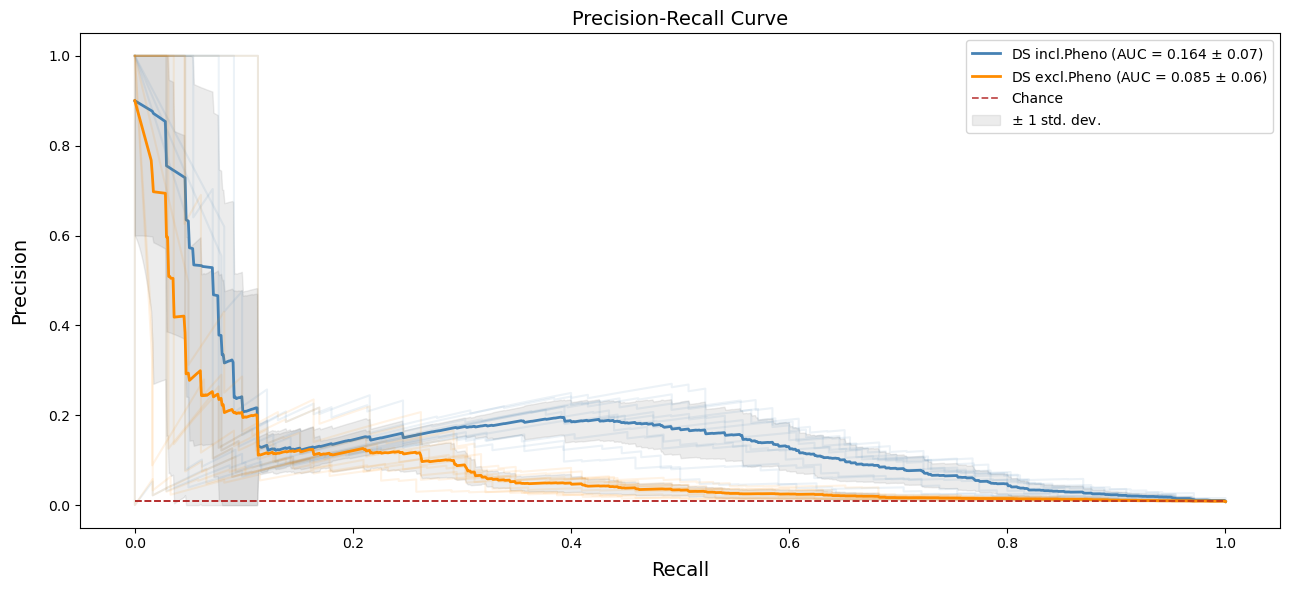

In [67]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from arbock.model.performance_evaluation import xval_roc_curve, xval_pr_curve

def extract_data_dict(input_file, rwr_proba):
    df = pd.read_csv(input_file, sep="\t")

    gene_pair_to_val = {}
    for idx, val in df.iterrows():
        sample = tuple(val["gene_pair"].split("-"))
        gene_pair_to_val[sample] = val[f"RWR_{rwr_proba}"]

    return gene_pair_to_val

def logit_model_cv(X, y, weights):
    clf = LogisticRegression()
    X = X.reshape(-1, 1)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    folds_y_true= []
    folds_y_scores = []
    folds_weights = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_weights = weights[train_index]
        test_weights = weights[test_index]
        clf.fit(X_train, y_train, sample_weight=train_weights)
        pred_proba = clf.predict_proba(X_test)
        folds_y_true.append(np.array(y_test))
        folds_y_scores.append(np.array(pred_proba[:, 1]))
        folds_weights.append(test_weights)

    return folds_y_true, folds_y_scores, folds_weights

def get_xval_eval_data(input_file, kg, rwr_proba):
    gene_pair_to_val = extract_data_dict(input_file, rwr_proba)

    neutral_pairs_path =  default_paths.neutral_pairs_path
    holdout_positive_size = default_params.holdout_positive_size
    positives, negatives, holdout_positives, sample_to_weight, sample_to_class = get_trainset_and_holdout(kg, neutral_pairs_path, holdout_positive_size)

    computed_vals = []
    classes = []
    weights = []
    for sample, clazz in sample_to_class.items():
        if sample in holdout_positives:
            continue
        computed_vals.append(gene_pair_to_val[sample])
        classes.append(clazz)
        weights.append(sample_to_weight[sample])

    X = np.array(computed_vals)
    y = np.array(classes)
    weights = np.array(weights)

    return logit_model_cv(X, y, weights)

rwr_proba = 0.7 # You can also try 0.3 and 0.5 (spoiler: it does not change much the results).
folds_y_true_pheno, folds_y_scores_pheno, folds_weights_pheno = get_xval_eval_data("models/article_predictions/RWR_probabilities_with_pheno.tsv", kg, rwr_proba)
folds_y_true_no_pheno, folds_y_scores_no_pheno, folds_weights_no_pheno = get_xval_eval_data("models/article_predictions/RWR_probabilities_no_pheno.tsv", kg, rwr_proba)

fig, ax = plt.subplots(1, 1, figsize=(13, 6))

xval_pr_curve("DS incl.Pheno", folds_y_true_pheno, folds_y_scores_pheno, folds_weights_pheno, ax=ax,
                   plot_color='steelblue', display_extra_legends=False)
xval_pr_curve("DS excl.Pheno", folds_y_true_no_pheno, folds_y_scores_no_pheno, folds_weights_no_pheno, ax=ax,
                   plot_color='darkorange')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.show()

Mined rules analysis
====================

In [54]:
# Useful functions and imports

from arbock.model.decision_set_classifier import DecisionSetClassifier

def prepare_rule_to_conf_data(model_path, kg):
    neutral_pairs_path = default_paths.neutral_pairs_path
    positives, negatives, holdout_positives, sample_to_weight, sample_to_class = get_trainset_and_holdout(kg, neutral_pairs_path, holdout_positive_size=0)
    imbalance_ratio = len(positives) / len(negatives)
    
    ds = DecisionSetClassifier.instanciate(model_path)

    rule_to_conf = {}
    for rule in ds.candidate_rules:
        conf = balanced_weighted_rule_confidence(rule, sample_to_weight, imbalance_ratio)
        rule_to_conf[rule] = conf
    return rule_to_conf

def prepare_rule_supp_conf_data(model_path, kg):
    neutral_pairs_path = default_paths.neutral_pairs_path
    positives, negatives, holdout_positives, sample_to_weight, sample_to_class = get_trainset_and_holdout(kg, neutral_pairs_path, holdout_positive_size=0)

    ds = DecisionSetClassifier.instanciate(model_path)
    rule_to_conf_support = defaultdict(dict)

    all_confs = []
    all_supps = []
    for rule in ds.candidate_rules:
        conf = balanced_weighted_rule_confidence(rule, sample_to_weight, len(positives)/len(negatives))
        supp = weighted_positive_support_ratio(rule, sample_to_weight, positives)

        rule_to_conf_support[rule]["conf"] = conf
        rule_to_conf_support[rule]["supp"] = supp
        rule_to_conf_support[rule]["Has unification"] = True if rule.antecedent.unification is not None else False
        all_confs.append(conf)
        all_supps.append(supp)

    df = pd.DataFrame.from_dict(rule_to_conf_support, orient="index")
    return df

def balanced_weighted_rule_confidence(rule, sample_to_weight, imbalance_ratio):
    TP = sum([sample_to_weight[s] for s in rule.positive_matches])
    FP = sum([sample_to_weight[s] for s in rule.negative_matches])

    return TP / (TP + (imbalance_ratio * FP)) if (TP+FP)>0 else 0

def weighted_positive_support_ratio(rule, sample_to_weight, positives):
    TP = sum([sample_to_weight[s] for s in rule.positive_matches])
    P = sum([sample_to_weight[s] for s in positives])
    return TP / P


Rule metapath content
---------------------

INFO:arbock.data_selection.data_retriever:Training data sizes: 441 positives | 44100 negatives | 0 holdout positives


Node type / edge type most represented in significant metapaths
G 81.2
a 75.0
p 56.2
BP 43.8
MF 18.8
e 18.8
CC 12.5
s 12.5
r 6.2
PF 6.2
b 6.2
u 6.2
PD 6.2


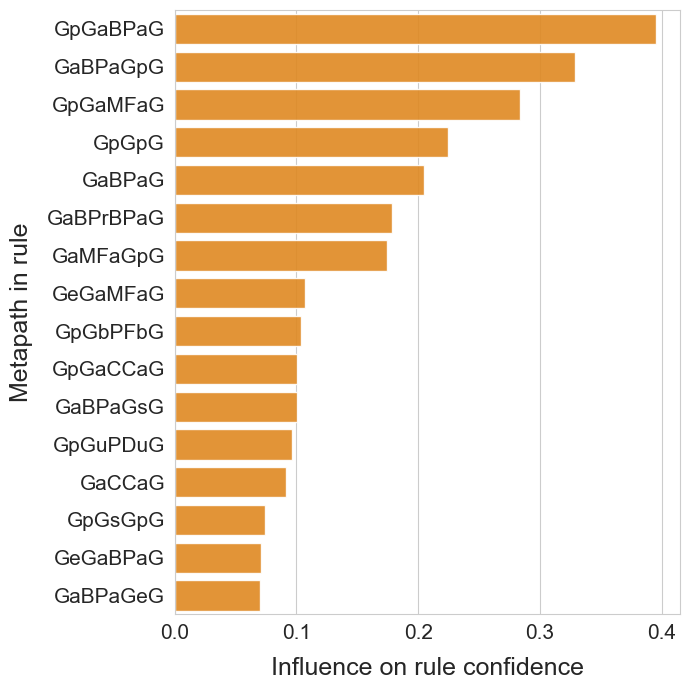

INFO:arbock.data_selection.data_retriever:Training data sizes: 441 positives | 44100 negatives | 0 holdout positives


Node type / edge type most represented in significant metapaths
a 93.8
G 75.0
P 50.0
p 43.8
BP 31.2
s 18.8
r 12.5
e 12.5
MF 12.5


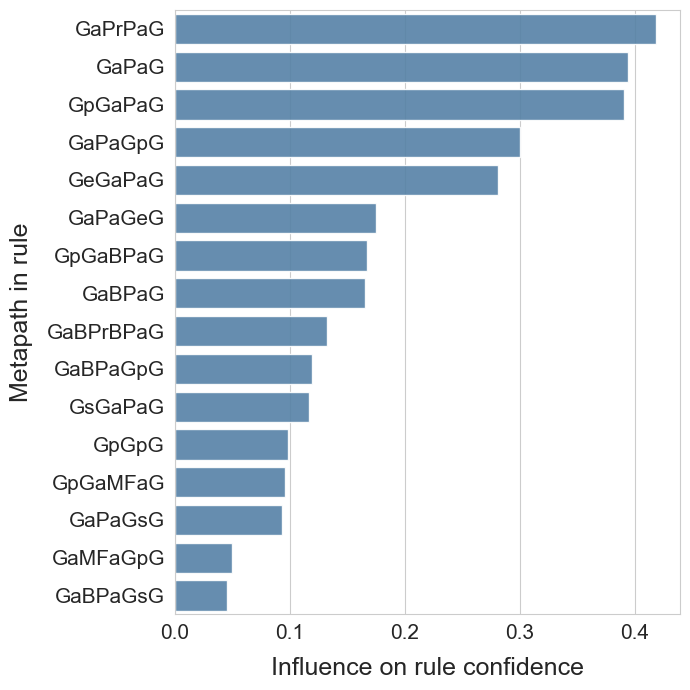

In [49]:
def plot_conf_wilcoxon_ranksum_metapaths(rule_to_conf, kg, color, color_nb):
    edge_type_to_rules = defaultdict(set)
    metapath_to_rules = defaultdict(set)
    for rule, confidence in rule_to_conf.items():
        metapaths = rule.antecedent.metapaths
        for metapath in metapaths:
            metapath_to_rules[metapath].add(rule)
            edge_types, node_types, edge_directions = metapath
            node_types = list(node_types)
            for i in range(len(node_types)-1):
                metaedge = (node_types[i], edge_types[i], node_types[i+1])
                edge_type_to_rules[metaedge].add(rule)
    rule_list = list(rule_to_conf.keys())
    metapath_to_corrpval = {}
    for metapath in metapath_to_rules:
        confidences_without_metapath = []
        confidences_with_metapath = []
        for rule in rule_list:
            if rule in metapath_to_rules[metapath]:
                confidences_with_metapath.append(rule_to_conf[rule])
            else:
                confidences_without_metapath.append(rule_to_conf[rule])
        _, pval = stats.ranksums(confidences_without_metapath, confidences_with_metapath, alternative="less")
        rbc = stats.rankdata(confidences_without_metapath + confidences_with_metapath)
        rbc_indicator = np.array([0] * len(confidences_without_metapath) + [1] * len(confidences_with_metapath))
        rbc_corr = stats.pointbiserialr(rbc_indicator, rbc)[0]

        metapath_abbrev = kg.nomenclature.abbreviate_metapath(metapath)
        metapath_to_corrpval[metapath_abbrev] = (pval, rbc_corr)

    corr_mp_df = pd.DataFrame.from_dict(metapath_to_corrpval, orient="index", columns=["pval", "effect_size"])
    corr_mp_df["metapath"] = corr_mp_df.index
    corr_mp_df = corr_mp_df.sort_values(by=["effect_size"], ascending=False)
    # Apply Bonferroni correction
    corr_mp_df["corrected_pval"] = corr_mp_df["pval"].apply(lambda x: min(x * len(metapath_to_corrpval), 1))
    corr_mp_df = corr_mp_df.loc[corr_mp_df["corrected_pval"] < 0.01]

    print("Node type / edge type most represented in significant metapaths")
    element_to_count = defaultdict(int)
    for metapath in list(corr_mp_df["metapath"]):
        for e in set([e for e in re.sub('([A-Z]+)', r'_\1_', metapath).split("_") if e][1:-1]):
            element_to_count[e] += 1

    for el, count in sorted(element_to_count.items(), key=lambda x: x[1], reverse=True):
        print(el, "%0.1f" % (count/len(list(corr_mp_df["metapath"])) * 100,))


    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(7, 7))

        #corr_mp_df["pval_log"] = -np.log10(corr_mp_df["pval"])

        palette = sns.light_palette(color, reverse=True, as_cmap=True)
        color_list = [mcolors.rgb2hex(palette(i)) for i in range(palette.N)]

        palette = sns.color_palette([color_list[color_nb]])

        ax = sns.barplot(y="metapath", x='effect_size', orient="h",
                         data=corr_mp_df, palette=palette, alpha=0.9)

        ax.tick_params(labelsize=15)
        plt.setp(ax.artists, edgecolor = 'k')
        plt.setp(ax.lines, color='k')
        ax.set(xlabel=None)
        ax.set_xlabel("Influence on rule confidence",fontsize=18, labelpad=10)
        ax.set_ylabel("Metapath in rule",fontsize=18, labelpad=10)

        plt.tight_layout()
        plt.show()

rule_to_conf = prepare_rule_to_conf_data("models/ds_model_no_pheno", kg)
plot_conf_wilcoxon_ranksum_metapaths(rule_to_conf, kg, "darkorange", 1)

rule_to_conf = prepare_rule_to_conf_data("models/ds_model_with_pheno", kg)
plot_conf_wilcoxon_ranksum_metapaths(rule_to_conf, kg, "steelblue", 1)

Rule metrics distribution
-------------------------

INFO:arbock.data_selection.data_retriever:Training data sizes: 441 positives | 44100 negatives | 0 holdout positives


<Figure size 1200x1200 with 0 Axes>

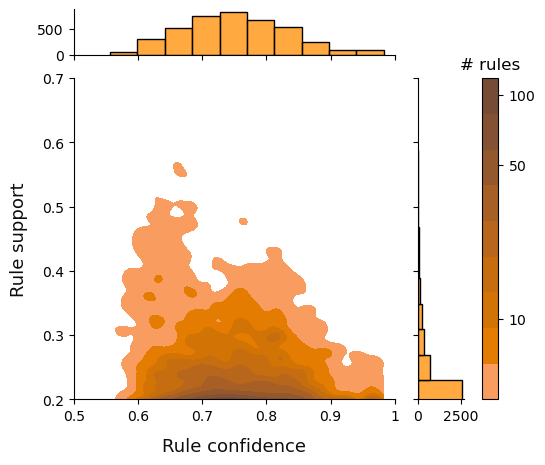

INFO:arbock.data_selection.data_retriever:Training data sizes: 441 positives | 44100 negatives | 0 holdout positives


<Figure size 1200x1200 with 0 Axes>

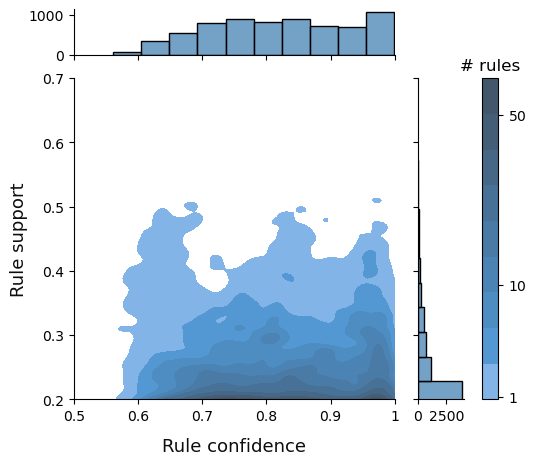

In [58]:
def plot_rule_metrics_distribution(df, color):

    plt.figure(figsize=(12, 12))

    palette = sns.dark_palette(color, reverse=True, as_cmap=True)
    color_list = [mcolors.rgb2hex(palette(i)) for i in range(palette.N)]

    palette = sns.color_palette(color_list)

    sns.set_palette(palette)
    norm = LogNorm()

    formatter = tkr.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    cbar_ticks = [1, 10, 50, 100, 200, 300, 400, 500]

    g = sns.JointGrid(data=df, x="conf", y="supp", marginal_ticks=True, xlim=(0.5,1), ylim=(0.2,0.7), space=0.5)
    g.plot_joint(sns.kdeplot, fill=True, bw_adjust=0.5, cut=0, thresh=0.02, cbar=True, norm=norm, cbar_kws={"ticks": cbar_ticks, "format": formatter})
    g.plot_marginals(sns.histplot, bins=10)

    xticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
    xtickLabels = map(str, xticks)
    g.ax_joint.set_xticks(xticks)
    g.ax_joint.set_xticklabels(xtickLabels)

    yticks = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    ytickLabels = map(str, yticks)
    g.ax_joint.set_yticks(yticks)
    g.ax_joint.set_yticklabels(ytickLabels)

    plt.subplots_adjust(left=0.15, right=0.8, top=0.8, bottom=0.15)

    # get the current positions of the joint ax and the ax for the marginal x
    pos_joint_ax = g.ax_joint.get_position()
    pos_marg_x_ax = g.ax_marg_x.get_position()
    # reposition the joint ax so it has the same width as the marginal x ax
    g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    # reposition the colorbar using new x positions and y positions of the joint ax
    g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

    g.fig.axes[-1].set_title('# rules')

    #g.ax_joint.set_xticks([i/10 for i in range(0,11)])

    g.set_axis_labels('Rule confidence', 'Rule support', fontsize=13, labelpad=10, alpha=0.95)

    plt.show()

df_rule_supp_conf = prepare_rule_supp_conf_data("models/ds_model_no_pheno", kg)
plot_rule_metrics_distribution(df_rule_supp_conf, "darkorange")

df_rule_supp_conf = prepare_rule_supp_conf_data("models/ds_model_with_pheno", kg)
plot_rule_metrics_distribution(df_rule_supp_conf, "steelblue")

ARBOCK Parameters Benchmark
===========================

Evaluating these parameter values with grid search (i.e 216 parameter combinations)

  "path_cutoff": [2, 3],
  "minsup_ratio": [0.2, 0.4, 0.6, 0.8],
  "max_rule_length": [2, 3, 4],
  "alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  
Performance is assessed by the mean ROC AUC from a 5-fold stratified cross-validation.

In [88]:
def get_parameter_analysis_data(perf_data_path, expl_data_path):
    merge_columns = ['sample_name', 'path_cutoff', 'minsup_ratio', 'max_rule_length', 'alpha']
    perf_df = pd.read_csv(perf_data_path, sep='\t')
    expl_df = pd.read_csv(expl_data_path, sep='\t')
    df = perf_df.merge(expl_df, on=merge_columns, how='outer')
    # Replace any other non-'False' values with 'True' and booleanize for all columns
    for column in df.columns:
        if not pd.api.types.is_bool_dtype(df[column]):
            unique_values = df[column].unique()
            unique_values_str = unique_values.astype(str)
            if len(unique_values) == 2 and 'False' in unique_values_str:
                df[column] = df[column].apply(lambda x: False if str(x) == 'False' else True)
                df[column] = df[column].astype(bool)
    return df

perf_data_path = "models/article_predictions/param_study_performance.tsv"
expl_data_path = "models/article_predictions/param_study_explanation_stats.tsv"

param_study_df = get_parameter_analysis_data(perf_data_path, expl_data_path)

Best performing models according to decision set alpha
------------------------------------------------------

For each alpha parameter value, we select the top performing models considering all sets of parameters (24 possible models per alpha).
Top performing models consider all models having a ROC AUC difference <= 0.01 compare to the best perfoming model.
Here we plot, for each alpha, the best model ROC AUC (i.e. performance) and the average number of rules and paths (i.e. explanation complexity) for each fold's test sets.
We can observe that performance is the highest at alpha = 0.5 and then plateau. Explanation complexity increases with alpha.
The other parameter values (path_cutoff, minsup_ratio, max_rule_length) are reported as average + std for these best performing models.

To make the effect of path_cutoff more evident, we also show the results when constraining path_cutoff=2.

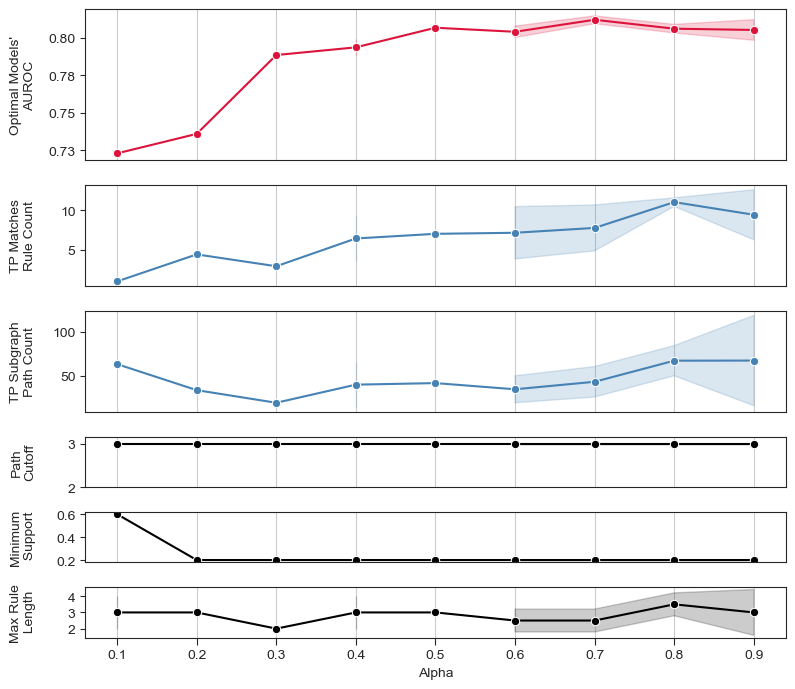

In [99]:
def plot_param_analysis_by_alpha(df, measured_metric, measured_metric_pretty, measure_best_is_high=True):
    unicity_parameter = ["path_cutoff", "minsup_ratio", "max_rule_length"]

    # Grouping by the keys and alpha, calculating mean measure
    mean_measure = df.groupby(unicity_parameter + ['alpha'])[measured_metric].mean().reset_index()

    # Calculating mean path count
    mean_path_count = df.groupby(unicity_parameter + ['alpha'])["mean_positive_path_counts"].mean().reset_index()

    # Calculating mean rule count
    mean_rule_count = df.groupby(unicity_parameter + ['alpha'])["mean_positive_rule_counts"].mean().reset_index()

    # Calculating mean entity count
    mean_entity_count = df.groupby(unicity_parameter + ['alpha'])["mean_positive_entity_counts"].mean().reset_index()

    mean_by_alpha_df = mean_measure.merge(mean_path_count, how='inner', on=unicity_parameter + ['alpha']) \
                                   .merge(mean_rule_count, how='inner', on=unicity_parameter + ['alpha']) \
                                   .merge(mean_entity_count, how='inner', on=unicity_parameter + ['alpha'])
    # Define a performance threshold for the difference in mean_balanced_acc
    performance_threshold = 0.01

    # Initialize an empty DataFrame to store the top N models
    top_n_models = pd.DataFrame()

    # Loop through each unique alpha value
    for alpha in mean_by_alpha_df['alpha'].unique():
        # Get the models for the current alpha value and sort them by mean_balanced_acc
        asc = not measure_best_is_high
        sorted_models = mean_by_alpha_df[mean_by_alpha_df['alpha'] == alpha].sort_values(measured_metric, ascending=asc).reset_index(drop=True)

        # Find the index where the difference in mean_balanced_acc exceeds the performance_threshold
        diff_from_best = sorted_models[measured_metric] - sorted_models[measured_metric].iloc[0]
        drop_idx = (diff_from_best.abs() > performance_threshold).idxmax()
        #drop_idx = (sorted_models[measured_metric].diff().abs() > performance_threshold).idxmax()

        # Get the top N models
        top_n_alpha_models = sorted_models.iloc[:drop_idx]

        # Append the top N models to the top_n_models DataFrame
        top_n_models = pd.concat([top_n_models, top_n_alpha_models])

    top_n_models = top_n_models.reset_index()

    # Set the overall aesthetic.
    sns.set_style("ticks")

    # Creating the figure and GridSpec
    fig = plt.figure(figsize=(8, 7))
    gs = GridSpec(nrows=6, ncols=1, figure=fig, height_ratios=[3, 2, 2, 1, 1, 1])

    ax_main = fig.add_subplot(gs[0, 0])
    sns.lineplot(ax=ax_main, data=top_n_models, x='alpha', y=measured_metric, estimator=np.mean, color='#DC143C', errorbar="sd", err_kws={"alpha": 0.2}, marker='o')
    ax_main.set_ylabel(measured_metric_pretty)
    ax_main.set_xlabel('')
    formatter = FuncFormatter(lambda y, _: '{:.2f}'.format(y))
    ax_main.yaxis.set_major_formatter(formatter)
    ax_main.xaxis.set_tick_params(labelbottom=False)
    ax_main.xaxis.grid(True)
    ax_main.tick_params(axis='x', which='both', length=0)

    ax_rule = fig.add_subplot(gs[1, 0], sharex=ax_main)
    sns.lineplot(ax=ax_rule, data=top_n_models, x='alpha', y='mean_positive_rule_counts', marker='o', errorbar="sd", err_kws={"alpha": 0.2})
    ax_rule.set_ylabel('TP Matches\nRule Count')
    ax_rule.set_xlabel('')
    ax_rule.xaxis.set_tick_params(labelbottom=False)
    ax_rule.xaxis.grid(True)
    ax_rule.tick_params(axis='x', which='both', length=0)

    ax_path = fig.add_subplot(gs[2, 0], sharex=ax_main)
    sns.lineplot(ax=ax_path, data=top_n_models, x='alpha', y='mean_positive_path_counts', marker='o', errorbar="sd", err_kws={"alpha": 0.2})
    ax_path.set_ylabel('TP Subgraph\nPath Count')
    ax_path.set_xlabel('')
    ax_path.xaxis.set_tick_params(labelbottom=False)
    ax_path.xaxis.grid(True)
    ax_path.tick_params(axis='x', which='both', length=0)

    ax_pc = fig.add_subplot(gs[3, 0], sharex=ax_main)
    sns.lineplot(ax=ax_pc, data=top_n_models, x='alpha', y='path_cutoff', marker='o', color='black', errorbar="sd", err_kws={"alpha": 0.2})
    ax_pc.set_yticks([2, 3])
    ax_pc.set_ylabel('Path\nCutoff')
    ax_pc.set_xlabel('')
    ax_pc.xaxis.set_tick_params(labelbottom=False)
    ax_pc.xaxis.grid(True)
    ax_pc.tick_params(axis='x', which='both', length=0)

    ax_msr = fig.add_subplot(gs[4, 0], sharex=ax_main)
    sns.lineplot(ax=ax_msr, data=top_n_models, x='alpha', y='minsup_ratio', marker='o', color='black',  errorbar="sd", err_kws={"alpha": 0.2})
    ax_msr.set_yticks([top_n_models['minsup_ratio'].min(), 0.4, top_n_models['minsup_ratio'].max()])
    ax_msr.set_ylabel('Minimum\n Support')
    ax_msr.set_xlabel('')
    ax_msr.xaxis.set_tick_params(labelbottom=False)
    ax_msr.xaxis.grid(True)
    ax_msr.tick_params(axis='x', which='both', length=0)

    ax_mrl = fig.add_subplot(gs[5, 0], sharex=ax_main)
    sns.lineplot(ax=ax_mrl, data=top_n_models, x='alpha', y='max_rule_length', marker='o', color='black',  errorbar="sd", err_kws={"alpha": 0.2})
    ax_mrl.set_yticks([2, 3, 4])
    ax_mrl.set_ylabel('Max Rule\n Length')
    ax_mrl.set_xlabel('Alpha')
    ax_mrl.xaxis.grid(True)
    ax_mrl.tick_params(axis='x', which='both', length=5)

    for ax in fig.axes:
        ax.yaxis.set_label_coords(-0.07, 0.5)

    plt.tight_layout()
    plt.show()

plot_param_analysis_by_alpha(param_study_df, "roc_auc", "Optimal Models'\nAUROC", True)

Effect of minsup_ratio / max_rule_length parameters
---------------------------------------------------

Here we fix alpha = 0.5 and report ROC AUC (performance) and #paths on test sets (explanation complexity) for various minsup_ratio and max_rule_length values.

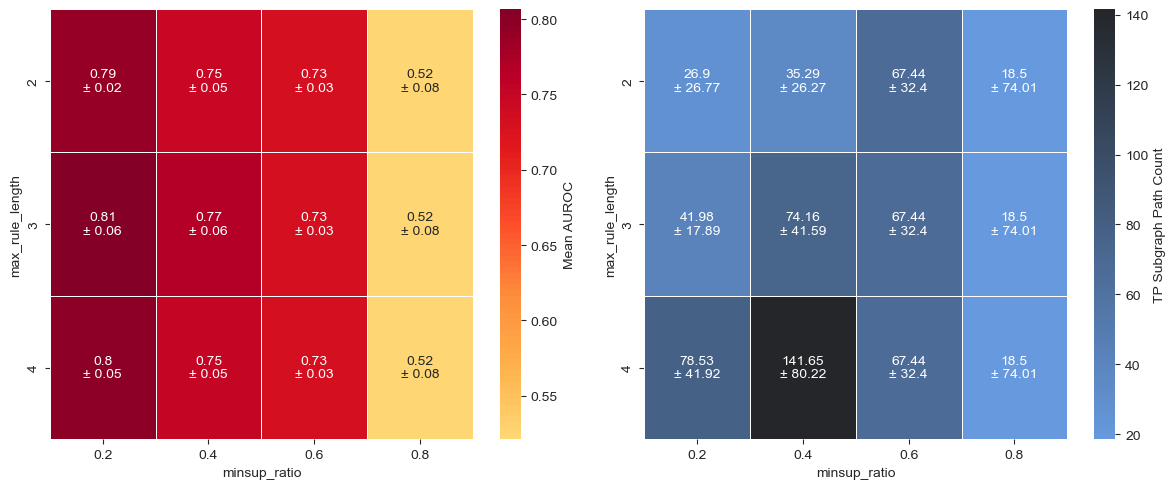

In [102]:
def paths(df, ax, path_cutoff):
    df = df.query(f"alpha == 0.5 and path_cutoff == {path_cutoff}")

    cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

    pivot_table = df.pivot_table(index='max_rule_length', columns='minsup_ratio',
                                 values='mean_positive_path_counts', aggfunc=[np.mean, lambda x: 2*np.std(x)])

    mean_values = pivot_table['mean']
    twice_std_values = pivot_table[('<lambda>')]

    formatted_values = mean_values.round(2).astype(str) + "\n± " + twice_std_values.round(2).astype(str)

    # Create the heatmap
    sns.heatmap(data=mean_values, annot=formatted_values, fmt='', ax=ax, cmap=cmap, cbar_kws={'label': 'TP Subgraph Path Count'}, linewidths=0.5)


def performance(df, ax, path_cutoff):
    df = df.query(f"alpha == 0.5 and path_cutoff == {path_cutoff}")

    palette = sns.color_palette("YlOrRd", n_colors=100)
    cmap = palette[25:]  # Start from orange-ish color


    pivot_table = df.pivot_table(index='max_rule_length', columns='minsup_ratio',
                                 values='roc_auc', aggfunc=[np.mean, lambda x: 2*np.std(x)])

    mean_values = pivot_table['mean']
    twice_std_values = pivot_table[('<lambda>')]

    formatted_values = mean_values.round(2).astype(str) + "\n± " + twice_std_values.round(2).astype(str)

    # Create the heatmap
    sns.heatmap(data=mean_values, annot=formatted_values, fmt='', ax=ax, cmap=cmap, cbar_kws={'label': 'Mean AUROC'}, linewidths=0.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
performance(param_study_df, axes[0], path_cutoff=3)
paths(param_study_df, axes[1], path_cutoff = 3)
plt.tight_layout()
plt.show()

Effect of path_cutoff = 2
---------------------------
Checking path_cutoff = 2 only.
We can observe that considering all the other parameters, the best performing models only reach maximum avg. 0.67 ROC AUC.
As expected, the number of paths provided in explanations is lower.

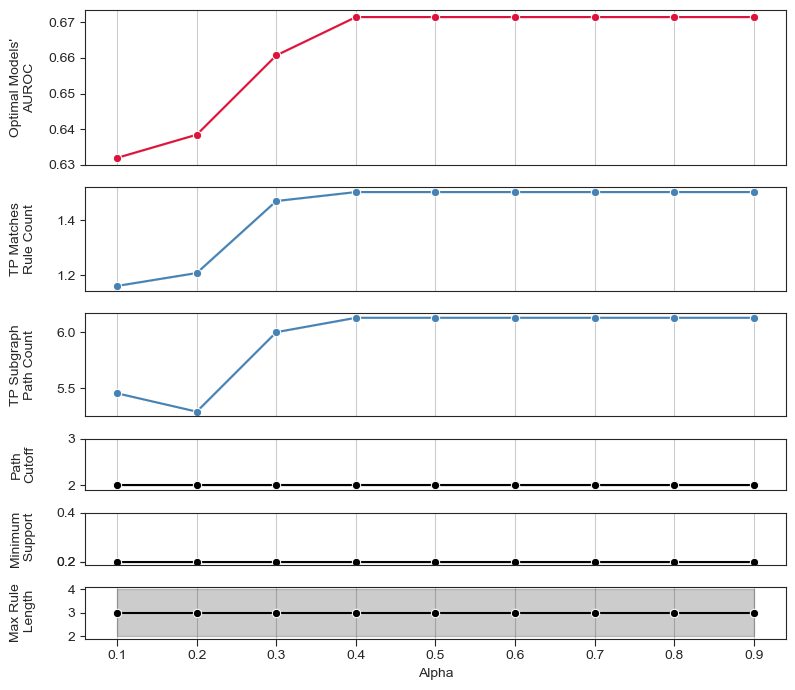

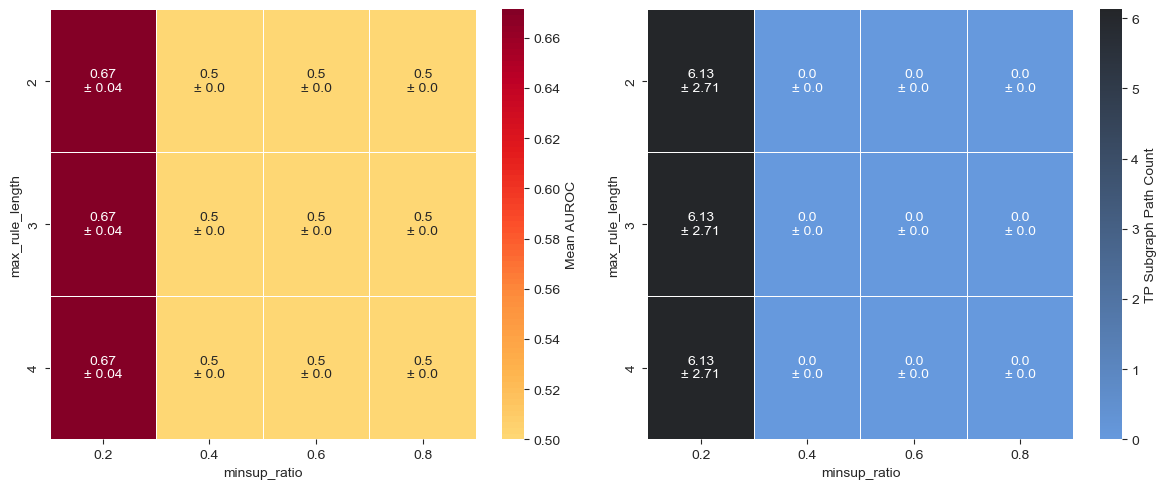

In [104]:
# Top models for all parameters, with fixed path_cutoff = 2, according to alpha
param_study_df_pc2 = param_study_df.query("path_cutoff==2")
plot_param_analysis_by_alpha(param_study_df_pc2, "roc_auc", "Optimal Models'\nAUROC", True)

# Alpha = 0.5 ; path_cutoff = 2 ; heatmap according to minsup_ratio and max_rule_length
path_cutoff = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
performance(param_study_df, axes[0], path_cutoff=path_cutoff)
paths(param_study_df, axes[1], path_cutoff=path_cutoff)
plt.tight_layout()
plt.show()

BOCK metaedge ablation study
============================

Here we assess performance and explanation complexity when removing one type of edge (metaedge) at a time.
A metaedge is defined as the type of edge together with adjacent node types (e.g Gene-associated-BiologicalProcess ; or GaBP)

Note that we did this assessment on the model trained without Phenotype information, since we showed earlier the high bias Phenotype introduces.
You can refer to the comparison with/without phenotype earlier, which shows the main effect of removing phenotype on performance.

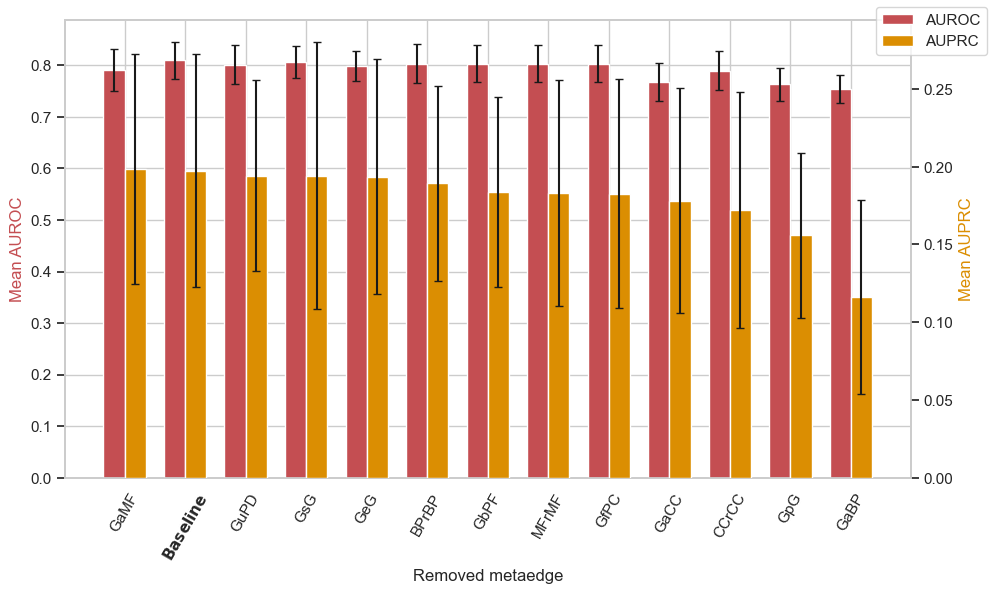

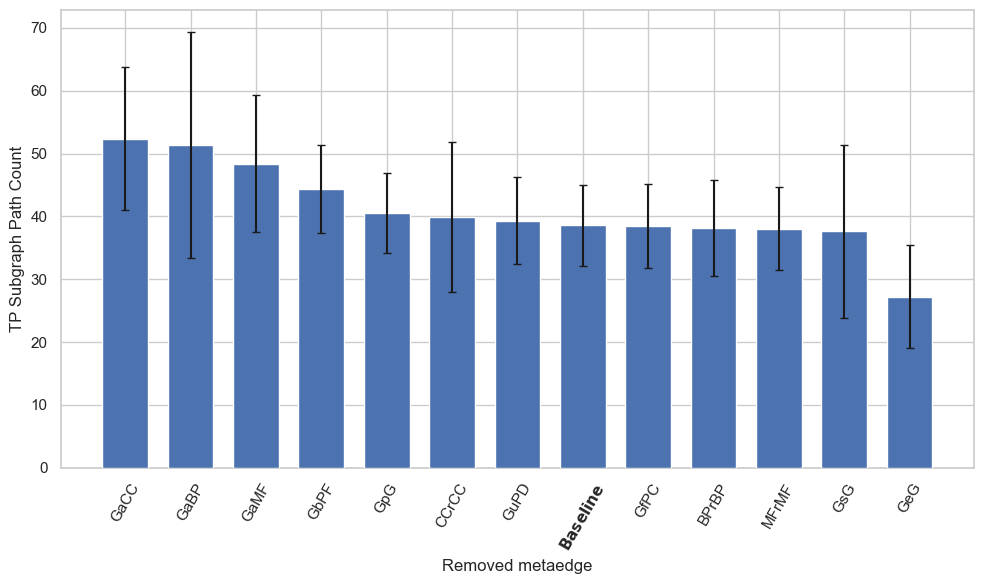

In [14]:
def get_metaedge_value(sample_name):
    match = re.search(r'metaedge_exclusion_model_(\w+)--(\w+)--(\w+)_(\d+)', sample_name)
    if match:
        result = match.groups()
        return result[:3]
    else:
        return None

def load_metaedge_ablation_data(df, metric, kg):
    metaedge_to_metric = defaultdict(list)
    for idx, val in df.iterrows():
        metaedge = get_metaedge_value(val["sample_name"])
        metric_val = val[metric]
        metaedge_to_metric[metaedge].append(metric_val)

    df_list = []
    for metaedge, metric_vals in metaedge_to_metric.items():
        mean = statistics.mean(metric_vals)
        std = statistics.stdev(metric_vals)
        df_list.append({
            "metaedge": metaedge,
            "metaedge_abbrev": kg.nomenclature.abbreviate_metaedge(metaedge, 0) if metaedge is not None else None,
            f"mean_{metric}": mean,
            f"std_{metric}": std
        })
    df = pd.DataFrame(df_list)
    return df

def load_all_metaedge_ablation_data(kg):
    perf_df = pd.read_csv(f"models/article_predictions/metaedge_ablation_no_pheno_performance_stats.tsv", sep="\t")
    expl_df = pd.read_csv(f"models/article_predictions/metaedge_ablation_no_pheno_explanation_stats.tsv", sep="\t")
    avg_roc_df = load_metaedge_ablation_data(perf_df, "roc_auc", kg)
    avg_pr_df = load_metaedge_ablation_data(perf_df, "pr_auc", kg)
    avg_expl_df = load_metaedge_ablation_data(expl_df, "mean_positive_path_counts", kg)

    avg_perf_df = pd.merge(avg_roc_df, avg_pr_df, on=["metaedge", "metaedge_abbrev"])
    final_df = pd.merge(avg_perf_df, avg_expl_df, on=["metaedge", "metaedge_abbrev"])
    return final_df


def ablation_performance_barplot(df):
    df['metaedge_abbrev'] = df['metaedge_abbrev'].fillna('Baseline')

    df = df.sort_values('mean_pr_auc', ascending=False)

    sns.set_theme(style="whitegrid")

    fig, ax1 = plt.subplots(figsize=(10, 6))

    width = 0.35
    ind = np.arange(len(df['metaedge_abbrev']))

    ax1.bar(ind - width/2, df['mean_roc_auc'], width, yerr=df['std_roc_auc'],
                          capsize=3, color="r", label='AUROC', zorder=3)
    ax2 = ax1.twinx()
    ax2.bar(ind + width/2, df['mean_pr_auc'], width, yerr=df['std_pr_auc'],
                         capsize=3, color='#db8e02', label='AUPRC', zorder=3)

    ax1.set_xlabel('Removed metaedge')
    ax1.set_ylabel('Mean AUROC', color="r")
    ax2.set_ylabel('Mean AUPRC', color='#db8e02')

    ax1.set_xticks(ind)
    labels = df['metaedge_abbrev'].tolist()
    labels = [r'$\bf{' + label + '}$' if label == 'Baseline' else label for label in labels]
    ax1.set_xticklabels(labels, rotation=60, ha="center")

    ax1.grid(zorder=0)
    ax2.grid(False)

    fig.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

def ablation_explanation_paths_barplot(df):
    df['metaedge_abbrev'] = df['metaedge_abbrev'].fillna('Baseline')

    df = df.sort_values('mean_mean_positive_path_counts', ascending=False)

    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.7
    ind = np.arange(len(df['metaedge_abbrev']))

    ax.bar(ind, df['mean_mean_positive_path_counts'], width,
                            yerr=df['std_mean_positive_path_counts'], capsize=3,
                            color='b', label='Mean Positive Path Counts', zorder=3)

    ax.set_xlabel('Removed metaedge')
    ax.set_ylabel('TP Subgraph Path Count')

    ax.set_xticks(ind)

    labels = df['metaedge_abbrev'].tolist()
    labels = [r'$\bf{' + label + '}$' if label == 'Baseline' else label for label in labels]
    ax.set_xticklabels(labels, rotation=60, ha="center")

    ax.grid(zorder=0)
    fig.tight_layout()
    plt.show()

metaedge_ablation_df = load_all_metaedge_ablation_data(kg)
ablation_performance_barplot(metaedge_ablation_df)
ablation_explanation_paths_barplot(metaedge_ablation_df)